In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"
# algo = "monolithic"
prefilter_strategy = "oracle"
scorer = "cross_entropy"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_neighbors = 10
parallel = False


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

add_data_prefilter_strategy = "both"
assign_labels_strategy = "groundtruth"

# train_cfg['num_epochs'] = 15
train_cfg['component_update_freq'] = train_cfg['num_epochs']
train_cfg['save_freq'] = 10
# num_comms_per_task = 3 # should really add 1 because the last comm is kinda basically useless
num_comms_per_task = 6 # should really add 1 because the last comm is kinda basically useless
# for the current task.
comm_freq = train_cfg['num_epochs'] // num_comms_per_task

# train_cfg['memory_size'] = 32
shared_memory_size = agent_cfg['memory_size']

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 20,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": shared_memory_size,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
    "use_ood_separation_loss": False,
    "assign_labels_strategy": assign_labels_strategy,
    "add_data_prefilter_strategy": add_data_prefilter_strategy,
})

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [5]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)

In [6]:
def setup_fleet(task_id=None): 
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)
    if task_id is not None:
        fleet.load_model_from_ckpoint(task_ids=task_id)
        fleet.update_replay_buffers(task_id)
    return fleet

In [7]:
fleet = setup_fleet(task_id=3)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [8]:
# """
# Viz query. Each row is a task. Each column is a query.
# The label is {score}/{y}/{y_pred}, and
# `red` means y != y_pred, `green` means y == y_pred.
# """
# agent_id = 0
# query_task_id = 0
# agent = fleet.agents[agent_id]
# X_queries, y_queries, y_pred_queries, score_queries = agent.compute_query(task_id=4, debug_return=True)

# num_neighbors = len(X_queries.keys())
# num_queries = max([len(X_queries[i]) for i in range(num_neighbors)])
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries*2, num_neighbors*2))

# rows = [f"task {task_id}" for task_id in range(num_neighbors)]
# pad = 0
# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# for task_id in range(num_neighbors):
#     for query_id in range(len(X_queries[task_id])):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(X_queries[task_id][query_id].squeeze(), cmap="gray")
#         color = "green" if y_queries[task_id][query_id]  ==  y_pred_queries[task_id][query_id] else "red"
#         ax.set_title(f"{score_queries[task_id][query_id]:.2f}/{y_queries[task_id][query_id]}/{y_pred_queries[task_id][query_id]}",
#                      color=color)

   
# plt.tight_layout()

In [9]:
fleet.communicate(task_id=4, end_epoch=92, comm_freq=10, num_epochs=100)

In [10]:
agent_id = 0
agent = fleet.agents[agent_id]
neighbor_id = 1
task_id = 0
# query = agent.query[task_id]
# Y = agent.incoming_extra_info[neighbor_id]['Y_neighbors'][task_id]
# Y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0])


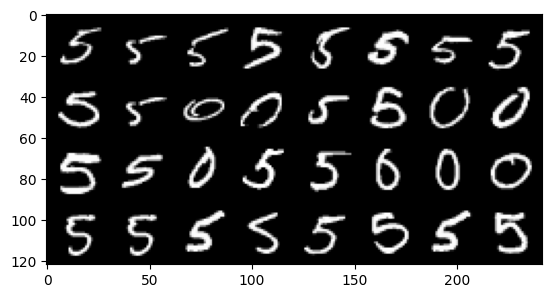

In [11]:
X, y, t = agent.agent.shared_replay_buffers[task_id].get_tensors()
plt.imshow(make_grid(X, nrow=8).permute(1,2,0))
print(y)

In [12]:
# extra_info = agent.incoming_extra_info[neighbor_id]
# shared_global_Y = extra_info['Y_neighbors'][task_id]
# shared_local_Y = get_local_labels_for_task(
#     shared_global_Y.flatten(), task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
# shared_local_Y.dtype

In [13]:
# shared_local_Y

In [14]:
# valid_mask

In [15]:
# plt.imshow(make_grid(query).permute(1, 2, 0))

In [16]:
# X = agent.incoming_data[neighbor_id][task_id]
# X = X.reshape(-1, *X.shape[2:])
# X.shape

In [17]:
# extra_info = agent.incoming_extra_info[neighbor_id]

# task_neighbors_prefilter = extra_info[
#     'task_neighbors_prefilter'][task_id]
# valid_rows_mask = ~torch.all(
#     task_neighbors_prefilter == -1, dim=1)

# valid_rows_mask.unsqueeze(1).expand(-1, task_neighbors_prefilter.shape[1]).reshape(-1).shape

In [18]:
# task_neighbors_prefilter.shape

In [19]:
# get_local_labels_for_task(Y.flatten(), task_id, agent.dataset.class_sequence, 
#                           agent.dataset.num_classes_per_task).reshape(Y.shape)

In [20]:
# agent.incoming_extra_info[neighbor_id]['task_neighbors_prefilter'][task_id]

In [21]:
# agent.incoming_extra_info[neighbor_id]['X_neighbors'][task_id].shape

In [22]:
# X = agent.incoming_extra_info[neighbor_id]['X_neighbors'][task_id]
# X = X.reshape(-1, *X.shape[2:])
# plt.imshow(make_grid(X).permute(1,2,0));

In [23]:
# neighbor_data = [agent.incoming_extra_info[neigh_id]['X_neighbors'][query_task_id] for neigh_id in agent.incoming_data.keys()]
# neighbor_data = [task_data.reshape(-1, *task_data.shape[2:]) for task_data in neighbor_data]

# # Calculate number of rows (tasks) and columns (queries)
# num_neighbors = len(neighbor_data)
# num_queries = max([len(data) for data in neighbor_data])  # Assuming each task has a list of data

# # Create subplots
# fig, axes = plt.subplots(num_neighbors, num_queries, figsize=(num_queries * 2, num_neighbors * 2))

# # Set row labels
# rows = [f"neighbor {neigh_id}" for neigh_id in agent.incoming_data.keys()]
# pad = 0
# for ax, row in zip(axes[:, 0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

# # Plot data
# for task_id, task_data in enumerate(neighbor_data):
#     for query_id in range(len(task_data)):
#         ax = axes[task_id, query_id]
#         ax.set_xticks([])
#         ax.set_yticks([])

#         ax.imshow(task_data[query_id].squeeze(), cmap="gray")

# plt.tight_layout()

In [24]:
# replay = agent.agent.shared_replay_buffers[query_task_id]
# plt.imshow(make_grid(replay.tensors[0][:len(replay)]).permute(1,2,0));

## The performance of baseline fleet

In [25]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)

test_task_id = 4
fleet = setup_fleet(task_id=test_task_id)
baseline_perfs = fleet.eval_test(test_task_id)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


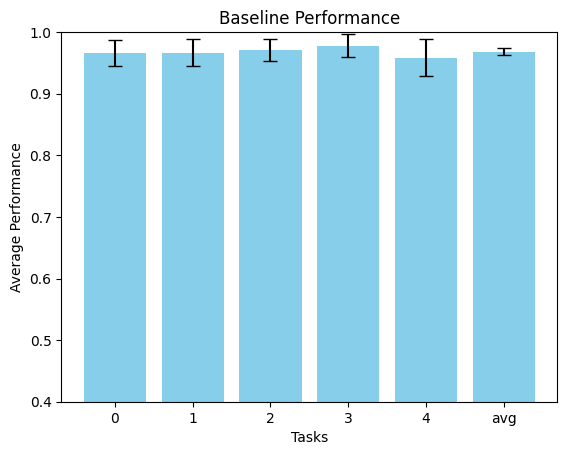

In [26]:
df = pd.DataFrame(baseline_perfs)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [27]:
task_stats

,0,1,2,3,4,avg
mean,0.965758,0.966875,0.971429,0.977758,0.958175,0.967999
std,0.020935,0.021769,0.017790,0.018548,0.030025,0.005467


In [28]:
df

,0,1,2,3,4,avg
0,0.963675,0.980924,0.966495,0.980422,0.976970,0.973697
1,0.972637,0.974479,0.968524,0.987940,0.958868,0.972489
2,0.960725,0.935564,0.986301,0.984353,0.987100,0.970809
3,0.918744,0.989447,0.979104,0.989458,0.957311,0.966813
4,0.988442,0.973161,0.931762,0.985923,0.980618,0.971981
5,0.968303,0.985264,0.986014,0.993311,0.892014,0.964981
6,0.979688,0.963701,0.982206,0.938004,0.967010,0.966122
7,0.973853,0.932460,0.971022,0.962651,0.945513,0.957100


## Receiver Sharing

In [29]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel=True)
FleetCls = get_fleet(cfg.sharing_strategy, parallel=True)

fleet = setup_fleet(task_id=test_task_id-1)
before_sharing_and_learn = fleet.eval_test(test_task_id)

INFO:root:No. gpus per agent: 0.25
2024-02-06 15:39:20,925	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(ParallelRecvDataAgent pid=3505999) INFO:root:Agent: node_id: 0, seed: 0
(ParallelRecvDataAgent pid=3506000) INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
(ParallelRecvDataAgent pid=3506001) INFO:root:Agent: node_id: 2, seed: 2000
(ParallelRecvDataAgent pid=3506002) INFO:root:Agent: node_id: 3, seed: 3000
(ParallelRecvDataAgent pid=3506061) INFO:root:Agent: node_id: 4, seed: 4000
(ParallelRecvDataAgent pid=3506122) INFO:root:Agent: node_id: 5, seed: 5000
(ParallelRecvDataAgent pid=3506220) INFO:root:Agent: node_id: 6, seed: 6000
(ParallelRecvDataAgent pid=3506303) INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Fleet initialized


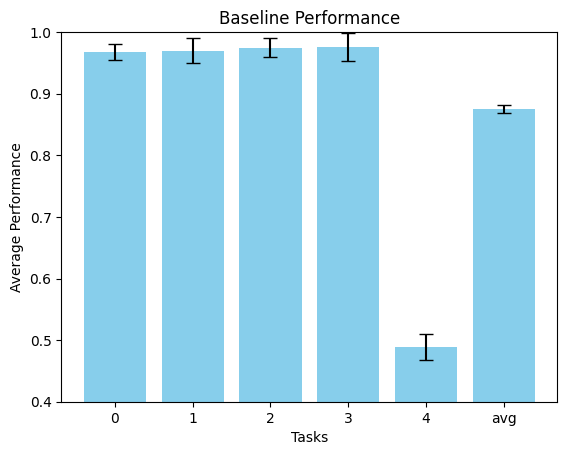

In [30]:
df = pd.DataFrame(before_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [31]:
task_stats

,0,1,2,3,4,avg
mean,0.967941,0.969998,0.974802,0.975594,0.488476,0.875362
std,0.013370,0.020782,0.014952,0.022742,0.020903,0.006823


In [32]:
print(fleet.get_save_dir())
fleet.change_save_dir(f'experiment_results/test_recv_global_labels/{algo}/{dataset}/{assign_labels_strategy}/{add_data_prefilter_strategy}')
print(fleet.get_save_dir())

['experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_0', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_1', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_2', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_3', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_4', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_5', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_6', 'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/

In [33]:
fleet.train_and_comm(task_id=test_task_id)

(ParallelRecvDataAgent pid=3505999) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 4	loss: 0.69328047	acc: 0.498
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: avg	loss: 0.44011244	acc: 0.879
(ParallelRecvDataAgent pid=3506000) INFO:root:epochs: 0, training task: 4
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 0	loss: 0.37953345	acc: 0.970
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 1	loss: 0.35447751	acc: 0.975
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 2	loss: 0.38573264	acc: 0.966
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 3	loss: 0.40629087	acc: 0.988
(ParallelRecvDataAge

training from 0 to 16
comm at epoch 16


(ParallelRecvDataAgent pid=3506303) INFO:root:epochs: 21, training task: 4
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 4	loss: 0.69336318	acc: 0.524
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: avg	loss: 0.45475991	acc: 0.875
(ParallelRecvDataAgent pid=3506000) INFO:root:epochs: 21, training task: 4
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 0	loss: 0.37953345	acc: 0.970
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 1	loss: 0.35447751	acc: 0.975
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 2	loss: 0.38573264	acc: 0.966
(ParallelRecvDataAgent pid=3506000) INFO:root:	task: 3	loss: 0.40629087	acc: 0.988
(ParallelRecvDataA

training from 16 to 32
comm at epoch 32


(ParallelRecvDataAgent pid=3506303) INFO:root:epochs: 41, training task: 4
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 4	loss: 0.69184730	acc: 0.947
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: avg	loss: 0.45445674	acc: 0.960
(ParallelRecvDataAgent pid=3506002) INFO:root:epochs: 41, training task: 4
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 0	loss: 0.40698826	acc: 0.945
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 1	loss: 0.35209568	acc: 0.988
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 2	loss: 0.38127397	acc: 0.980
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 3	loss: 0.35618965	acc: 0.987
(ParallelRecvDataA

training from 32 to 48
comm at epoch 48


(ParallelRecvDataAgent pid=3506303) INFO:root:epochs: 51, training task: 4
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 4	loss: 0.69134716	acc: 0.954
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: avg	loss: 0.45435671	acc: 0.961
(ParallelRecvDataAgent pid=3506002) INFO:root:epochs: 51, training task: 4
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 0	loss: 0.40698826	acc: 0.945
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 1	loss: 0.35209568	acc: 0.988
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 2	loss: 0.38127397	acc: 0.980
(ParallelRecvDataAgent pid=3506002) INFO:root:	task: 3	loss: 0.35618965	acc: 0.987
(ParallelRecvDataA

training from 48 to 64
comm at epoch 64


(ParallelRecvDataAgent pid=3506303) INFO:root:epochs: 71, training task: 4
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 4	loss: 0.69110740	acc: 0.960
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: avg	loss: 0.45430876	acc: 0.962
(ParallelRecvDataAgent pid=3506001) INFO:root:epochs: 71, training task: 4
(ParallelRecvDataAgent pid=3506001) INFO:root:	task: 0	loss: 0.39762004	acc: 0.965
(ParallelRecvDataAgent pid=3506001) INFO:root:	task: 1	loss: 0.37774693	acc: 0.954
(ParallelRecvDataAgent pid=3506001) INFO:root:	task: 2	loss: 0.37510298	acc: 0.988
(ParallelRecvDataAgent pid=3506002) INFO:root:epochs: 71, training task: 4
(ParallelRecvDataAgent pid

training from 64 to 80
comm at epoch 80


(ParallelRecvDataAgent pid=3506303) INFO:root:epochs: 81, training task: 4
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 0	loss: 0.37277447	acc: 0.977
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 1	loss: 0.45240000	acc: 0.928
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 2	loss: 0.38272549	acc: 0.981
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 3	loss: 0.37253642	acc: 0.965
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: 4	loss: 0.69132552	acc: 0.964
(ParallelRecvDataAgent pid=3506303) INFO:root:	task: avg	loss: 0.45435238	acc: 0.963
(ParallelRecvDataAgent pid=3505999) INFO:root:epochs: 81, training task: 4
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
(ParallelRecvDataAgent pid=3505999) INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
(ParallelRecvDataA

training from 80 to 96
comm at epoch 96


(ParallelRecvDataAgent pid=3506303) INFO:root:candidate 4: W/update: 0.94, WO/update: 0.52, improv 0.8076923076923075
(ParallelRecvDataAgent pid=3506303) INFO:root:Keeping new module 4. Total: 5
(ParallelRecvDataAgent pid=3506001) INFO:root:candidate 4: W/update: 0.99, WO/update: 0.42, improv 1.3571428571428574
(ParallelRecvDataAgent pid=3506001) INFO:root:Keeping new module 4. Total: 5
(ParallelRecvDataAgent pid=3506122) INFO:root:candidate 4: W/update: 0.92, WO/update: 0.48, improv 0.9166666666666669
(ParallelRecvDataAgent pid=3506122) INFO:root:Keeping new module 4. Total: 5
(ParallelRecvDataAgent pid=3505999) INFO:root:candidate 4: W/update: 0.99, WO/update: 0.53, improv 0.8679245283018867
(ParallelRecvDataAgent pid=3505999) INFO:root:Keeping new module 4. Total: 5
(ParallelRecvDataAgent pid=3506000) INFO:root:candidate 4: W/update: 0.97, WO/update: 0.48, improv 1.0208333333333333
(ParallelRecvDataAgent pid=3506000) INFO:root:Keeping new module 4. Total: 5
(ParallelRecvDataAgent pi

training from 96 to 100


(ParallelRecvDataAgent pid=3506220) INFO:root:final components: 5


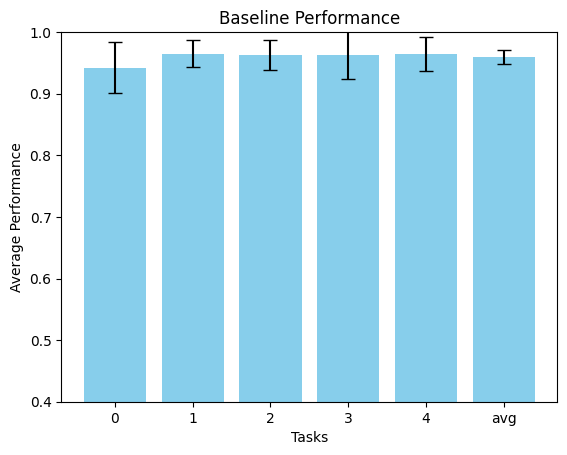

In [34]:
after_sharing_and_learn = fleet.eval_test(test_task_id)
df = pd.DataFrame(after_sharing_and_learn)
df.columns = df.columns.astype(str)

task_stats = df.agg(["mean", "std"])
plt.bar(task_stats.columns, task_stats.loc['mean'], yerr=task_stats.loc['std'], capsize=5, color='skyblue')
plt.xlabel('Tasks')
plt.ylabel('Average Performance')
plt.title('Baseline Performance')
plt.ylim(0.4, 1.0)  
plt.show()

In [35]:
task_stats

,0,1,2,3,4,avg
mean,0.941915,0.965055,0.963461,0.962274,0.964823,0.959506
std,0.041464,0.022412,0.024200,0.039043,0.027916,0.010732


In [36]:
df

,0,1,2,3,4,avg
0,0.875000,0.976908,0.928866,0.979418,0.983112,0.948661
1,0.935323,0.977083,0.945304,0.982915,0.974359,0.962997
2,0.975831,0.965035,0.991970,0.978189,0.990444,0.980294
3,0.895813,0.991457,0.954229,0.991466,0.955176,0.957628
4,0.988442,0.974652,0.940108,0.955757,0.976004,0.966993
5,0.937117,0.957825,0.987879,0.992833,0.901055,0.955342
6,0.940625,0.961145,0.981698,0.876008,0.974227,0.946741
7,0.987173,0.916331,0.977631,0.941610,0.964209,0.957391


In [37]:
agent = fleet.agents[0]
shared_reps = ray.get(agent.get_shared_replay_buffers.remote())
reps = ray.get(agent.get_replay_buffers.remote())

0 tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1])
1 tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 0])
2 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])
3 tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0])
4 tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1])


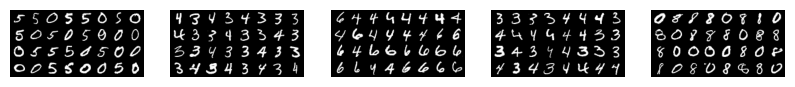

In [38]:
fig, axes = plt.subplots(1, len(reps), figsize=(len(reps)*2, 2))
for task_id, rep in sorted(reps.items()):
        X, y, t = rep.get_tensors()
        print(task_id, y)
        axes[task_id].imshow(make_grid(X).permute(1,2,0))
        axes[task_id].axis('off')

0 tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1]) 

1 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]) 

2 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]) 

3 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1]) 

4 tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0]) 



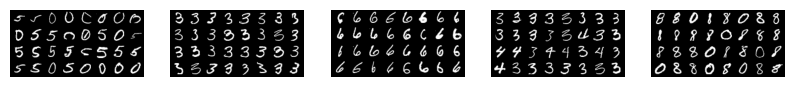

In [39]:
fig, axes = plt.subplots(1, len(shared_reps), figsize=(len(reps)*2, 2))
for task_id, shared_rep in sorted(shared_reps.items()):
    X, y, t = shared_rep.get_tensors()
    print(task_id, y, '\n')
    axes[task_id].imshow(make_grid(X).permute(1,2,0))
    axes[task_id].axis('off')

In [51]:
query = ray.get(agent.get_query.remote())

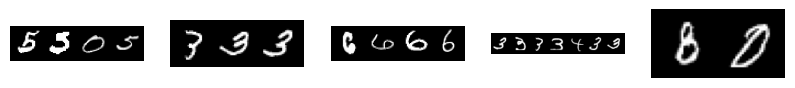

In [60]:
fig, ax = plt.subplots(1, len(query), figsize=(len(query)*2, 2))
for task_id, task_query in query.items():
    ax[task_id].imshow(make_grid(task_query).permute(1,2,0))
    ax[task_id].axis('off')

__TODO__

This is probably the same class balancing problem!